<a href="https://colab.research.google.com/github/Xavier-ML/Computational-Physics-with-Python/blob/main/09b_MC_magnet_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating a magnet using a Monte Carlo algorithm

- by Börge Göbel

In [24]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

(-1.1, 1.1)

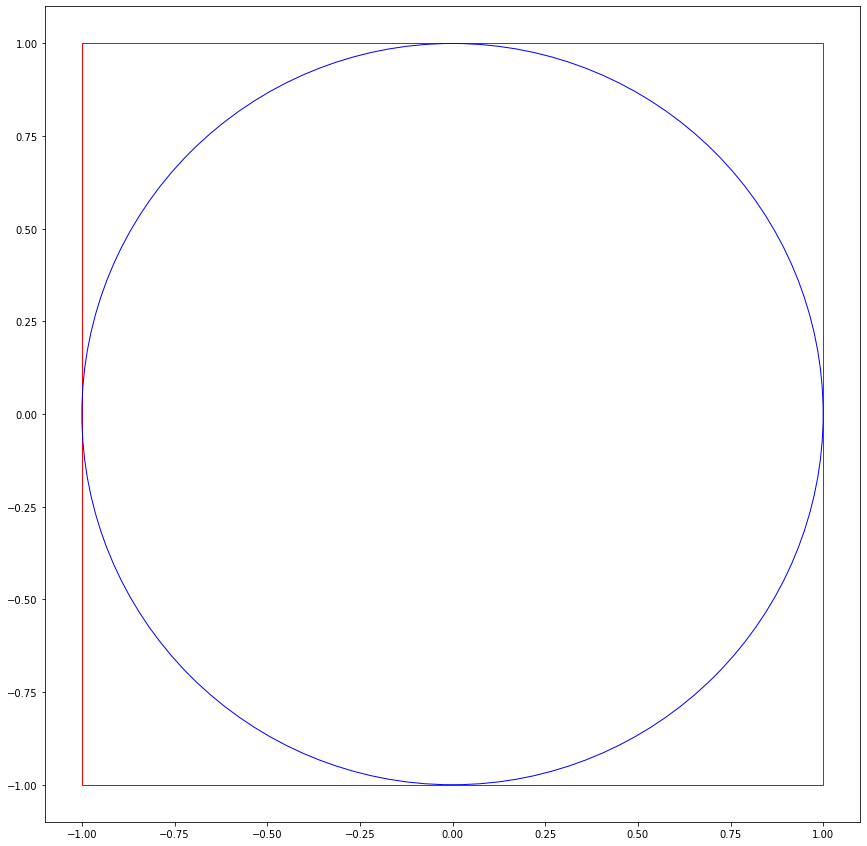

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect = "equal")
plt.rcParams['figure.figsize'] = [15, 15]

rectangle = patches.Rectangle((-1,-1),2,2,facecolor = "none", edgecolor = "red")
ax.add_patch(rectangle)

circle = patches.Circle((0,0),1,facecolor = "none", edgecolor = "blue")
ax.add_patch(circle)

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

**Measure the area ratio by counting randomly generated points**

In [26]:
points = 1000

rand = 2*np.random.rand( 2*points) -1

In [27]:
rand

array([ 0.50265834,  0.73237256,  0.06988724, ..., -0.22917007,
        0.93834825,  0.25412271])

In [28]:
randpoints = rand.reshape(points, 2)

In [29]:
randpoints

array([[ 0.50265834,  0.73237256],
       [ 0.06988724,  0.16191231],
       [-0.01153467,  0.62158554],
       ...,
       [ 0.9274151 , -0.78582308],
       [-0.98936935, -0.22917007],
       [ 0.93834825,  0.25412271]])

In [30]:
normpoints = randpoints[:,0]**2 + randpoints[:,1]**2

In [31]:
normpoints[0]

0.7890349664575322

In [32]:
pointsOut = randpoints[normpoints > 1]
pointsIn = randpoints[normpoints <= 1]

In [33]:
piapprox = 4*len(pointsIn)/points
print(piapprox)

3.116


In [34]:
piapprox - np.pi

-0.025592653589793013

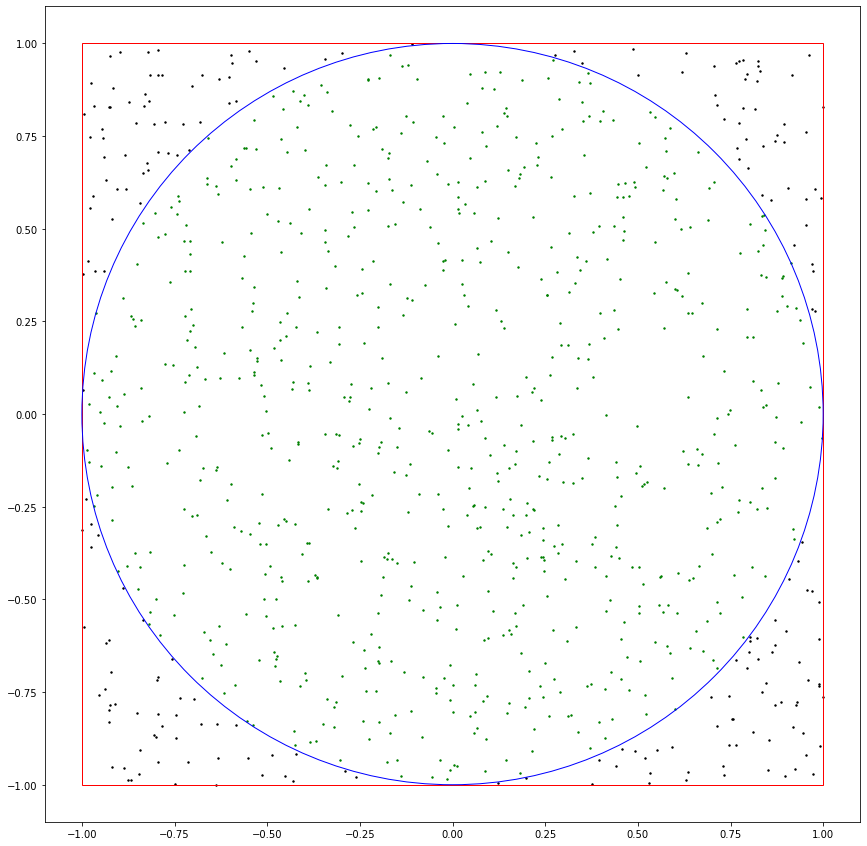

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect = "equal")
plt.rcParams['figure.figsize'] = [10, 10]

rectangle = patches.Rectangle((-1,-1),2,2,facecolor = "none", edgecolor = "red")
ax.add_patch(rectangle)

circle = patches.Circle((0,0),1,facecolor = "none", edgecolor = "blue")
ax.add_patch(circle)

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

plt.scatter(pointsIn[:,0],pointsIn[:,1], color = "green", s=2)
plt.scatter(pointsOut[:,0],pointsOut[:,1], color = "black", s=2)

**Alternative: Loop method**

In [36]:
i=0
counter = 0

while i<=points:
    if np.linalg.norm(np.random.rand(2)-1) < 1:
        counter = counter + 1
    i = i + 1


In [37]:
piapprox = 4*counter/points
print(piapprox)

3.168


**Comparative method over time**

In [38]:
%%timeit

rand = 2*np.random.rand( 2*points) -1
randpoints = rand.reshape(points, 2)
normpoints = randpoints[:,0]**2 + randpoints[:,1]**2
pointsIn = randpoints[normpoints <= 1]
piapprox = 4*len(pointsIn)/points

35.6 µs ± 912 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Loop method

In [39]:
%%timeit

i=0
counter = 0

while i<=points:
    if np.linalg.norm(np.random.rand(2)-1) < 1:
        counter = counter + 1
    i = i + 1

piapprox = 4*counter/points

6.41 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 1. Generate starting configuration

We start with a randomly generated array of magnetic moments \\( \{ \vec{m}_1, \vec{m}_2, \dots, \vec{m}_n \} \\). The length of each moment is fixed \\( |\vec{m}_i| = 1 \\) but the orientation is chosen randomly. We can construct this by generating a random polar angle \\( \varphi_i \\) and azimutal angle \\( \theta_i \\) and using spherical coordinates:

\\( \vec{m}_i = \begin{pmatrix} \cos\varphi_i\sin\theta_i \\ \sin\varphi_i\sin\theta_i \\ \cos\theta_i \end{pmatrix} \\)

In [40]:
length = 20
num = length**2

randphi = 2*np.pi*np.random.rand(num).reshape(length,length, 1)
randtheta = np.pi*np.random.rand(num).reshape(length,length,1 )

In [41]:
randtheta.shape

(20, 20, 1)

### Magnetic moments

In [42]:
mag = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta)])

In [43]:
mag[:,5,2,0]

array([-0.39009232,  0.45917532, -0.79811403])

In [44]:
# check norm
np.sqrt( mag[0,:]**2 + mag[1,:]**2 + mag[2,:]**2 )[5,2,0]

1.0

### Positions

In [45]:
coords = np.array(np.meshgrid(np.arange(length), np.arange(length),np.arange(1)))

### Plot

In [46]:
# Change standard size of all figures in this notebook
plt.rcParams['figure.figsize'] = [40, 15]

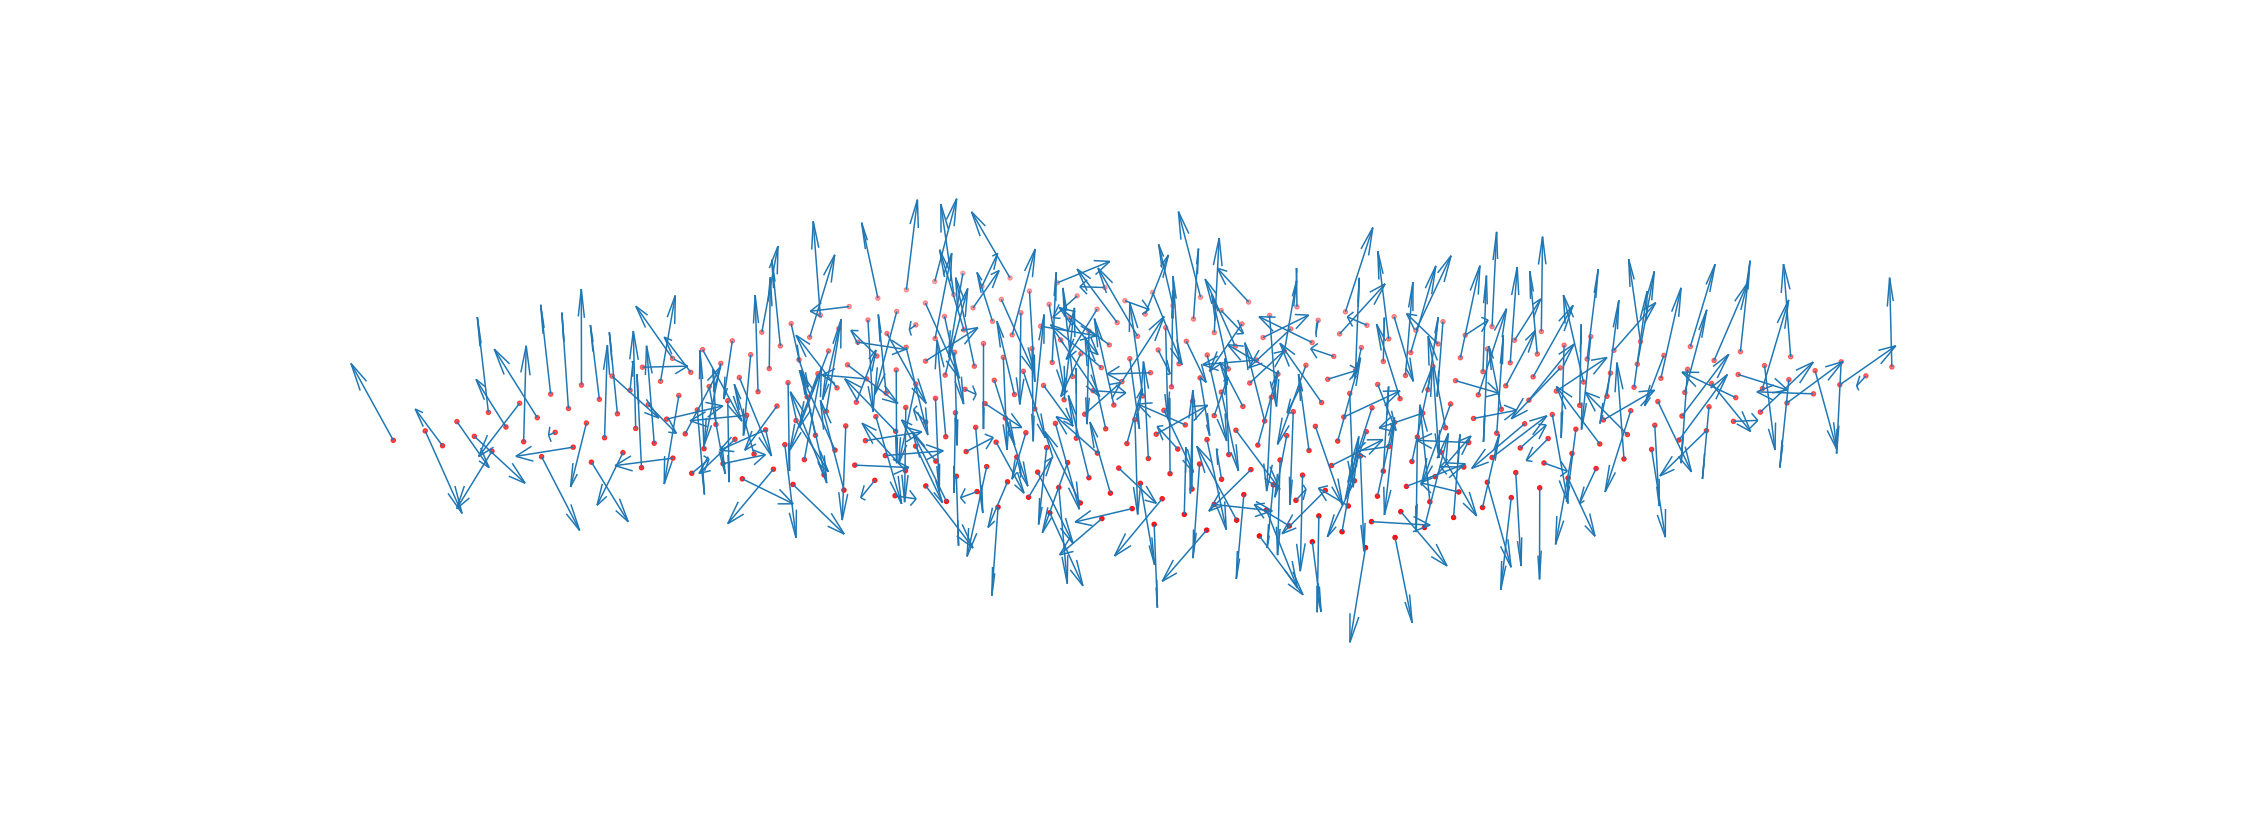

In [ ]:
arrowplot = plt.axes(projection = "3d")
arrowplot.set_zlim(-2,2)
#arrowplot.set_box_aspect(aspect = (length, length, 2))

# make background invisible
arrowplot.axis(False)

#Quiver plot
arrowplot.quiver(
    coords[0],coords[1],coords[2],
    mag[0],mag[1],mag[2]
)

# Coordinate plot
arrowplot.scatter3D(coords[0],coords[1],coords[2], color = "red")

## 2. Calculating the energy 

We are searching for the configuration with the lowest energy. For a ferromagnet the energy can be written as:

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j  \\) 

Every moment is interacting with its direct neighbor (\\( <i,j> \\)) and prefers a parallel orientation as long as \\( J > 0\\). Of course, there exist additional energy terms that have to be considered for a realistic ferromagnet but we will neglect them for now. 

In [49]:
np.dot( mag[:,5,2,0],mag[:,6,2,0] + mag[:,4,2,0] + mag[:,5,3,0] + mag[:,5,1,0] )

2.029172880027949

In [ ]:
def energyExchange(mag):
    # mag: Array magnetic moments
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energyExchangeContribution(mag,x,y)
    return energy

__Update 2 (skip for the beginning):__ We can apply an external magnetic field \\( \vec{B} \\). This leads to the energy:

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu \sum_i \vec{B}\cdot \vec{m}_i \\) 

__Update 3 (skip for the beginning):__ We include the Dzyaloshinskii–Moriya interaction (asymmetric exchange).

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu B \sum_i m_i^{(z)}  + \frac{1}{2}\sum_{<i,j>}\vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right)\\) 

The vectors \\( \vec{D}_{ij} \\) are determined by the symmetry of the sample. In our example, they shall point along the direction \\( i \rightarrow j\\). 

As an example, let us consider a bond along the \\( x \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_x \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(y)}m_j^{(z)} - m_i^{(z)}m_j^{(y)} \right)\\) 

For a bond along the \\( y \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_y \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(z)}m_j^{(x)} - m_i^{(x)}m_j^{(z)} \right)\\) 

## 3. Metropolis step

Now to the actual Monte Carlo algorithm. We will repeditly do so-called Metropolis steps: 

1. A random magnetic moment is selected.
2. It is reoriented along a random direction.
3. The energy is calculated \\( E_\mathrm{new} \\).
4. The energy is compared to the old energy \\( E_\mathrm{old} \\): 
    - If the energy is decreased, the random change of the magnetic moment is accepted. 
    - If the energy is increased, the old magnetic moment is restored.

__Update 1 (skip for the beginning):__ For finite temperatures \\( T \\), we accept the change with a chance \\( \exp\left(-\frac{E_\mathrm{new}-E_\mathrm{old}}{k_BT}\right) \\)

__Update 2 (skip for the beginning):__ We include the energy corresponding to the interaction with the magnetic field:

__Update 3 (skip for the beginning):__ We include the energy corresponding to the Dzyaloshinskii–Moriya interaction (asymmetric exchange):

## 4. Run the Monte Carlo algorithm